In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
PATH_TRAIN = "/content/drive/MyDrive/Dokship_AI_Challange/Dataset/Classification_Dataset/Training_Dataset/Classification_Dataset/Training_Data/"

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 256 # or try size 128
IMG_WIDTH = 256 # or try size 128
CHANNELS = 3

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, size = [IMG_HEIGHT, IMG_WIDTH])

  return image

(256, 256, 3)


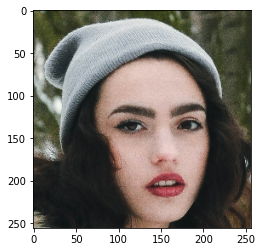

In [ ]:
import numpy as np
re = load(PATH_TRAIN+'Fake_Images/hard_226_0100.jpg')
plt.figure()
plt.imshow(re/255.0)
print(re.shape)

In [ ]:
refrence_image = re

In [ ]:
data_dir_list = os.listdir(PATH_TRAIN)
data_dir_list

['Real_Images', 'Fake_Images']

In [ ]:
img_data_list = []
image_path_list = []

In [ ]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH_TRAIN+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH_TRAIN+dataset+'/'+img
        image_path_list.append(img_path)
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, size = [IMG_HEIGHT, IMG_WIDTH])
        image = np.concatenate((image,refrence_image),2 )
        img_data_list.append(image)
        count = count+1
        if count == 700:
          break

  0%|          | 0/861 [00:00<?, ?it/s]

Loading the images of dataset - Real_Images



  0%|          | 0/760 [00:00<?, ?it/s]

Loading the images of dataset - Fake_Images




 92%|█████████▏| 699/760 [03:40<00:17,  3.57it/s]

In [ ]:
img_data = np.array(img_data_list)
img_data = img_data
print(img_data.shape)

(1400, 256, 256, 6)


In [ ]:
img_data.dtype

dtype('float32')

In [ ]:
num_classes = 2
num_of_samples = img_data.shape[0]
# do something with labels for the images
labels_zeros = np.zeros((700,30,30,1), dtype = 'float32') 
labels_ones = np.ones((700,30,30,1), dtype = 'float32')

In [ ]:
labels = np.concatenate((labels_zeros,labels_ones))

names = ['zeros_Real_Images', 'ones_Fake_Images']

labels.shape

(1400, 30, 30, 1)

In [ ]:
#Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,labels, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 1)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1260, 256, 256, 6)
(1260, 30, 30, 1)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(140, 256, 256, 6)
(140, 30, 30, 1)


Classification Model

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 6], name='input_image')
  #ref = tf.keras.layers.Input(shape=[256, 256, 3], name='refrence_image')

  #x = tf.keras.layers.concatenate([inp, ref]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(inp) # (bs, 128, 128, 64)
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down1) # (bs, 130, 130, 64)
  conv1 = tf.keras.layers.Conv2D(128, 4, strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv1)
  leaky_relu1 = tf.keras.layers.LeakyReLU()(batchnorm1)

  
  down2 = downsample(128, 4)(leaky_relu1) # (bs, 64, 64, 128)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 130, 130, 256)
  conv2 = tf.keras.layers.Conv2D(256, 4, strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad2) # (bs, 127, 127, 512)
  batchnorm2 = tf.keras.layers.BatchNormalization()(conv2)
  leaky_relu2 = tf.keras.layers.LeakyReLU()(batchnorm2)

  down3 = downsample(256, 4)(leaky_relu2) # (bs, 32, 32, 256)
  zero_pad3 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv3 = tf.keras.layers.Conv2D(512, 4, strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad3) # (bs, 31, 31, 512)
  batchnorm3 = tf.keras.layers.BatchNormalization()(conv3)
  leaky_relu3 = tf.keras.layers.LeakyReLU()(batchnorm3)

  zero_pad4 = tf.keras.layers.ZeroPadding2D()(leaky_relu3) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad4) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp], outputs=last)

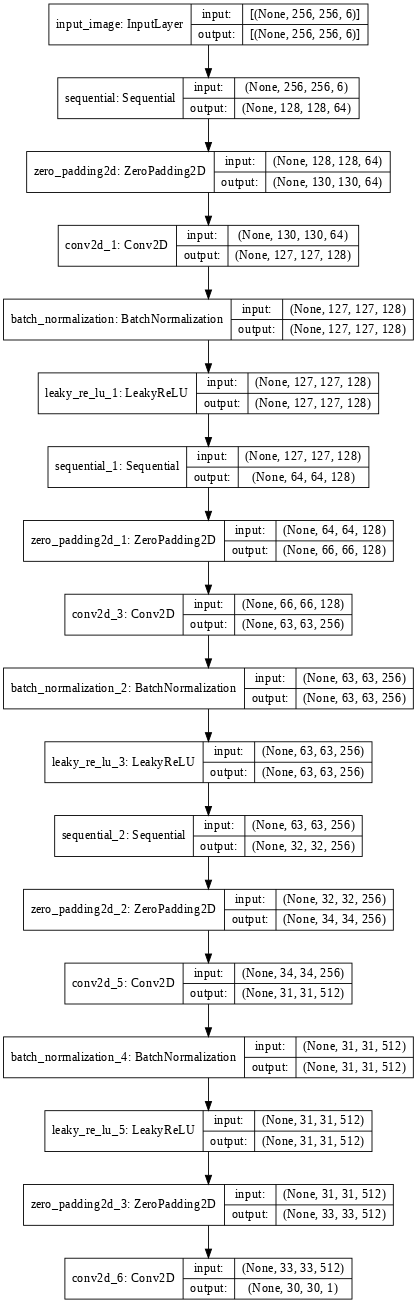

In [ ]:
Classifier_Model = Discriminator()
tf.keras.utils.plot_model(Classifier_Model, show_shapes=True, dpi=64)

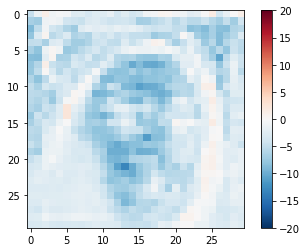

In [ ]:
disc_out = Classifier_Model([tf.expand_dims(img_data[500],0)], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
Classifier_Model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

In [ ]:
Classifier_Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 6)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 64)      6144      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 128)     131072    
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 127, 127, 128)     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 128)       262656

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('Fake_Face_Detector.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [ ]:
history = Classifier_Model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=1, validation_data = (X_test, y_test), callbacks = callbacks)

Epoch 1/30
40/40 [==============================] - 25s 552ms/step - loss: 7.1810 - accuracy: 0.4945 - val_loss: 7.6276 - val_accuracy: 0.4978
Epoch 2/30
40/40 [==============================] - 21s 524ms/step - loss: 7.3236 - accuracy: 0.5041 - val_loss: 7.6616 - val_accuracy: 0.4929
Epoch 3/30
40/40 [==============================] - 21s 522ms/step - loss: 7.1008 - accuracy: 0.5216 - val_loss: 7.5046 - val_accuracy: 0.5093
Epoch 4/30
40/40 [==============================] - 21s 526ms/step - loss: 7.5712 - accuracy: 0.4953 - val_loss: 7.7983 - val_accuracy: 0.4857
Epoch 5/30
40/40 [==============================] - 21s 533ms/step - loss: 7.6210 - accuracy: 0.4918 - val_loss: 7.7623 - val_accuracy: 0.4844
Epoch 6/30
40/40 [==============================] - 21s 533ms/step - loss: 7.6257 - accuracy: 0.4902 - val_loss: 7.7651 - val_accuracy: 0.4854
Epoch 7/30
40/40 [==============================] - 22s 539ms/step - loss: 7.6614 - accuracy: 0.4884 - val_loss: 7.6465 - val_accuracy: 0.4922

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


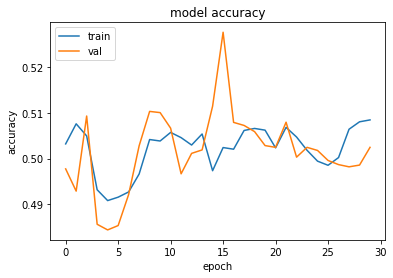

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'][0:50])
plt.plot(history.history['val_accuracy'][0:50])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

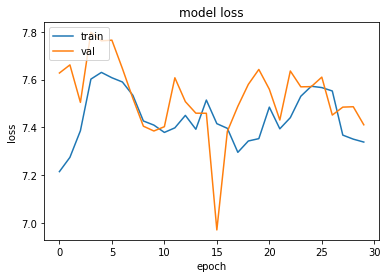

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'][0:50])
plt.plot(history.history['val_loss'][0:50])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()